In [1]:
import matplotlib.pyplot as plt
import numpy as np
import collresolve
G = 6.67408e-11
GM_earth = 3.986004e14
M_earth = GM_earth/G

# Functions

In [2]:
def density(mass, radius):
  volume = 4/3*np.pi*radius**3
  if isinstance(radius, (int, float)):
    return mass/volume if radius > 0 else np.inf
  else:
    return np.where(radius>0., mass/volume, np.inf)

def mass(density, radius):
  volume = 4/3*np.pi*radius**3
  if isinstance(radius, (int, float)):
    return density*volume if radius > 0 else np.inf
  else:
    return np.where(radius>0., density*volume, 0)

def radius(mass, density):
  volume = mass/density
  return (3/4/np.pi*volume)**(1/3)

def get_sim_res(data, sim_num):
  sim_mask = data[:,0] == sim_num
  return data[sim_mask, :][0]

def collresolve_orb(mt, gamma, theta, v_scale, rt, rp):
  conf = collresolve.Conf()
  collresolve.conf_unit_si(conf)
  collresolve.conf_model(conf, collresolve.MODEL_C2019)
  big = collresolve.Body(mass = mt*M_earth, radius = rt)
  small = collresolve.Body(mass = mt*M_earth*gamma, radius = rp)
  velocity = v_scale*collresolve.escape_velocity(conf, big, small)
  angle = np.radians(theta)
  collresolve.setup(conf, big, small, velocity, angle)
  res, regime = collresolve.resolve( conf, big, small, 3, 1 )
  big, small, info, debris = res
  # print(big.mass, big.radius, small.mass, small.radius, debris.mass, debris.pos_x, debris.pos_y, debris.pos_z)
  accs = np.array([info.mass, info.radius])
  orb = np.array([info.pos_x, info.pos_y, info.pos_z])
  score = np.array([info.vel_x, info.vel_y, info.vel_z,])
  return accs, orb, score
  
def coll_resolve_C2019(m1, r1, x1, y1, z1, vx1, vy1, vz1, m2, r2, x2, y2, z2, vx2, vy2, vz2):
  big = collresolve.Body(m1, r1, x1, y1, z1, vx1, vy1, vz1)
  small = collresolve.Body(m2, r2, x2, y2, z2, vx2, vy2, vz2)
  conf = collresolve.Conf()
  collresolve.conf_unit_merc(conf) # choose your units to be same as input data
  model = collresolve.MODEL_C2019
  collresolve.conf_model(conf, model)
  print( "impact velocity = {0:.1e} AU/day".format( collresolve.impact_velocity( conf, big, small ) ) )
  print( "velocity ratio = {0:.2f}".format( collresolve.impact_velocity( conf, big, small ) / collresolve.escape_velocity( conf, big, small ) ) )
  print( "impact angle = {0:.1f} deg".format( np.degrees( collresolve.impact_angle( conf, big, small ) ) ) )
  res, regime = collresolve.resolve( conf, big, small, 3, 1 )
  big, small, info, debris = res
  accs = np.array([info.mass, info.radius])
  orb = np.array([info.pos_x, info.pos_y, info.pos_z])
  score = np.array([info.vel_x, info.vel_y, info.vel_z,])
  return big, small, debris, accs, orb, score


# Analysis of the Database

|0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|Sim #|$M_t$|$M_t/M_p$|$CMF_t$|$CMF_p$|$V/V_{exc}$|$\theta$|$R_t$|$R_p$|SPH Regime|SPH $M_L$|SPH $R_L$|SPH $M_S$|SPH $R_S$|SPH $M_d$|CR Regime|CR $M_L$|CR $R_L$|CR $M_S$|CR $R_S$|CR $M_d$|CR $\epsilon'$|CR $b'$|CR $\Delta \omega'$|SPH $\epsilon'$|SPH $b'$|SPH $\Delta \omega'$|

In [3]:
database_res = np.loadtxt('/Users/rmelikyan/Documents/analysis_results.csv', delimiter=', ')
orb_res = np.genfromtxt('/Users/rmelikyan/Documents/orb.txt', delimiter='')
collres_orbs = np.zeros((len(database_res), 3))
for i, data in enumerate(database_res):
    accs, cr_orb, score = collresolve_orb(*data[[1, 2, 6, 5, 7, 8]])
    collres_orbs[i] = cr_orb
database_res = np.append(database_res, collres_orbs, 1)
orb_res[~(orb_res>0)] = 0
database_res = np.append(database_res[np.argsort(database_res[:, 0]),:], orb_res[:, [23,24,25]], 1)
database_res.shape

(1000, 27)

### Collresolve V1 parameter filters

In [4]:
min_mass = 1e-2 # Emass
max_mass = 1 # Emass
min_v = 1 # Vesc
max_v = 4 # Vesc
min_cmf = 0.2
max_cmf = 0.4

mass_filter = np.logical_and(database_res[:,1]>=min_mass, database_res[:,1]<=max_mass)
velocity_filter = np.logical_and(database_res[:,5] >= min_v, database_res[:,5] <= max_v)
cmfT_filter = np.logical_and(database_res[:,3]>=min_cmf, database_res[:,3]<=max_cmf)
cmfP_filter = np.logical_and(database_res[:,4]>=min_cmf, database_res[:,4]<=max_cmf)
v1_filter = np.logical_and(np.logical_and(mass_filter, velocity_filter), np.logical_and(cmfT_filter, cmfP_filter))
no_filt = database_res[:,0] > -1
print("From {} Simulations:\n\t{} pass the mass filter\n\t{} pass the velocity filter \n\t{} pass the CMF target filter\n\t{} pass the CMF impactor filter\nThis leaves {} simulations for fair comparison to Collresolve V1".format(len(database_res), sum(mass_filter), sum(velocity_filter), sum(cmfT_filter), sum(cmfP_filter), sum(v1_filter)))

From 1000 Simulations:
	425 pass the mass filter
	815 pass the velocity filter 
	333 pass the CMF target filter
	333 pass the CMF impactor filter
This leaves 38 simulations for fair comparison to Collresolve V1


In [22]:
lr_diff = 100*np.where(database_res[:, 10]>0, (database_res[:,10] - (database_res[:,16]))/database_res[:,10], (database_res[:,10] - (database_res[:,16]))/(M_earth*database_res[:,1]))
slr_diff = 100*np.where(database_res[:, 12]>0, (database_res[:,12] - (database_res[:,18]))/database_res[:,12], (database_res[:,12] - (database_res[:,18]))/(M_earth*np.multiply(*database_res[:,[1,2]].T)))
dbr_diff = 100*np.where(database_res[:, 14]>0, (database_res[:,14] - (database_res[:,20]))/database_res[:,14], (database_res[:,14] - (database_res[:,20]))/(M_earth*np.add(*database_res[:,[1,2]].T)))
eps_diff = 100*np.where(database_res[:,24] > 0, (database_res[:,24] - (database_res[:,21]))/database_res[:,24], 0)
b_diff = 100*(database_res[:,25] - (database_res[:,22]))/database_res[:,25]
delomega_diff = 100*(database_res[:,26] - (database_res[:,23]))/database_res[:,26]


/var/folders/78/9rvb24fn0tg7wb1qc72qvvcc0000gn/T/ipykernel_59327/1474554979.py:1: RuntimeWarning: divide by zero encountered in true_divide
  lr_diff = 100*np.where(database_res[:, 10]>0, (database_res[:,10] - (database_res[:,16]))/database_res[:,10], (database_res[:,10] - (database_res[:,16]))/(M_earth*database_res[:,1]))
/var/folders/78/9rvb24fn0tg7wb1qc72qvvcc0000gn/T/ipykernel_59327/1474554979.py:2: RuntimeWarning: divide by zero encountered in true_divide
  slr_diff = 100*np.where(database_res[:, 12]>0, (database_res[:,12] - (database_res[:,18]))/database_res[:,12], (database_res[:,12] - (database_res[:,18]))/(M_earth*np.multiply(*database_res[:,[1,2]].T)))
/var/folders/78/9rvb24fn0tg7wb1qc72qvvcc0000gn/T/ipykernel_59327/1474554979.py:2: RuntimeWarning: invalid value encountered in true_divide
  slr_diff = 100*np.where(database_res[:, 12]>0, (database_res[:,12] - (database_res[:,18]))/database_res[:,12], (database_res[:,12] - (database_res[:,18]))/(M_earth*np.multiply(*database_re

Text(0.5, 1.0, 'Energy Error')

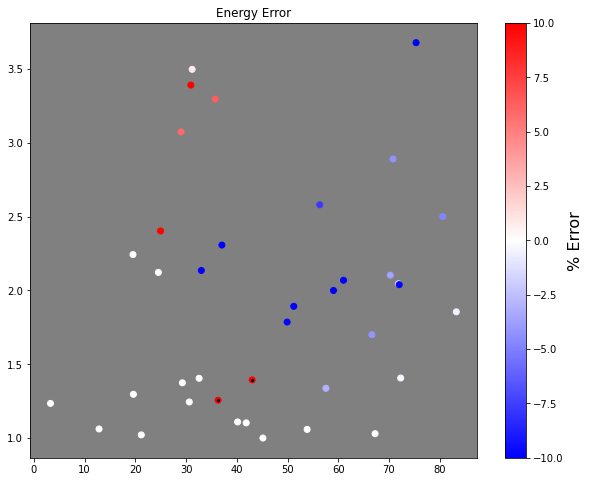

In [172]:
filter = v1_filter
special_filter = np.logical_and(filter, np.logical_and((database_res[:,24] != 0), (database_res[:,21] == 0)))
perc_cutoff = 10
plt.figure(figsize=(10, 8))
cbar = plt.scatter(database_res[filter,6], database_res[filter,5], c = eps_diff[filter], vmin=-perc_cutoff, vmax=perc_cutoff, cmap='bwr')
plt.scatter(database_res[special_filter,6], database_res[special_filter,5], c = 'black', s = 5)
# plt.xlabel('Target CMF', fontsize = 16)
# plt.ylabel('Impactor CMF', fontsize = 16)
plt.gca().set_facecolor('grey')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(.9, 4.1)
cbar = plt.colorbar(cbar)
cbar.set_label('% Error', fontsize = 16)
plt.title("Energy Error")

In [36]:
database_res[special_filter, 0]

array([ 72., 525.])

In [173]:
# fig, (ax1) = plt.subplots(1, 1, figsize = (10, 4))
# xlim = np.ceil(max(abs(lr_diff)))
# bins = np.arange(-xlim, xlim, .5)
# ax1.hist(lr_diff, bins = bins)
# ax1.grid()
# plt.xlabel('Percent Error')
# # bins = np.arrange(-5, 5, .5)

In [174]:
# fig, (ax1) = plt.subplots(1, 1, figsize = (10, 4))
# xlim = np.ceil(max(abs(slr_diff)))
# bins = np.arange(-xlim, xlim, .5)
# ax1.hist(lr_diff, bins = bins)
# ax1.grid()
# plt.xlabel('Percent Error')

In [171]:
# fig, (ax1) = plt.subplots(1, 1, figsize = (10, 4))
# xlim = np.ceil(max(abs(dbr_diff)))
# bins = np.arange(-xlim, xlim, .5)
# ax1.hist(lr_diff, bins = bins)
# ax1.grid()
# plt.xlabel('Percent Error')

In [175]:
# x = database_res[v1_filter,4]
# weights = np.where(x>.3, 3, 1)*lr_diff
# plt.subplot(211)
# hist, bins, _ = plt.hist(x, bins=20, weights=weights)

# # histogram on log scale. 
# # Use non-equal bin sizes, such that they look equal on log scale.
# # logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
# # plt.subplot(212)
# # plt.hist(x, bins=logbins, weights=weights)
# # plt.xscale('log')
# plt.show()

# Collresolve Impact Accretion Maps

In [177]:
res = 500
angles = np.linspace(0, 89.9, res)
vels = np.linspace(1, 4, res)
m = 0.25*M_earth
gamma = 0.5
r = 6371e3
acc_eff = np.zeros((res, res))
for i, theta in enumerate(angles):
    for j, v_scale in enumerate(vels):
        conf = collresolve.Conf()
        collresolve.conf_unit_si(conf)
        collresolve.conf_model(conf, collresolve.MODEL_C2019)
        big = collresolve.Body(mass=m, radius=r)
        small = collresolve.Body(mass=gamma*m, radius=gamma**(1/3)*r)
        velocity = v_scale*collresolve.escape_velocity(conf, big, small)
        collresolve.setup(conf, big, small, velocity, np.radians(theta))
        res, regime = collresolve.resolve( conf, big, small, 2, 1 )
        big, small, debris = res
        
        acc_eff[j,i] = (big.mass - m) / (m*gamma)

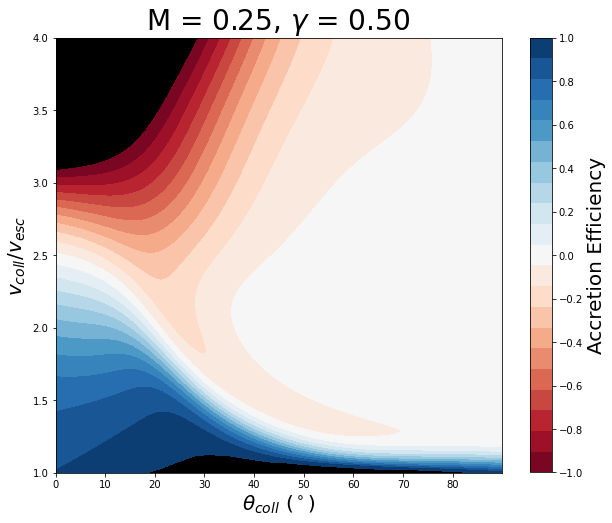

In [178]:
levels = np.linspace(-1, 1, 22)
plt.figure(figsize=(10, 8))
plt.contourf(angles, vels, acc_eff, levels = levels, cmap = 'RdBu')
plt.gca().set_facecolor('black')
cbar = plt.colorbar()
cbar.set_label('Accretion Efficiency', fontsize = 20)
cbar.set_ticks(np.arange(-1, 1.1, 0.2))
plt.xlabel('$\\theta_{coll}$ ($^\circ$)', fontsize = 20)
plt.ylabel('$v_{coll}/v_{esc}$', fontsize = 20)
plt.title('M = {:.2f}, $\\gamma$ = {:.2f}'.format(m/M_earth, gamma), fontsize=28)
plt.show()

## Density Profile

In [ ]:
ms = np.zeros(1000)
rhos = np.zeros(1000)
for i, m in enumerate(M_earth*np.logspace(-6, 0.1062, 1000)):
    conf = collresolve.Conf()
    collresolve.conf_unit_si(conf)
    collresolve.conf_model(conf, collresolve.MODEL_C2019)
    big = collresolve.Body(mass=m, radius=1e8)
    small = collresolve.Body(mass=1e-5*m, radius=1e3)
    velocity = 0.001*collresolve.escape_velocity(conf, big, small)
    angle = 45*np.pi/180
    collresolve.setup(conf, big, small, velocity, angle)
    res, regime = collresolve.resolve( conf, big, small, 2, 1 )
    big, small, debris = res
    ms[i] = big.mass/M_earth
    rhos[i] = density(big.mass, big.radius)

plt.semilogx(ms, rhos, c='black')

"{mtar:s}    {gamma:s}    {ctar:s}    {cimp:s}    {vel:s}    {angle:s}    {regime:d}    {acclrg:10.6f}    {accsrg:10.6f}    {acctrg:10.6f}    {rotlrf:10.6f}    {cmflrg:10.6f}    {inzlrf:10.6f}    {inalrf:10.6f}    {veltrg:10.6f}    {vrmstrg:10.6f}    {acclra:10.6f}    {accsra:10.6f}    {acctra:10.6f}    {rotlrb:10.6f}    {cmflra:10.6f}    {inzlrb:10.6f}    {inalrb:10.6f}    {eorba:10.6f}    {paraa:10.6f}    {peria:10.6f}    {rotsrb:10.6f}    {cmfsra:10.6f}    {inzsrb:10.6f}    {inasrb:10.6f}    {veltra:10.6f}    {vrmstra:10.6f}" 

|0|$M_t$|11|$CMF_l$|22|$Ina_l$|
|-|-|-|-|-|-|
|1|$\gamma$|12|$Inz_l$|23|$\epsilon'$|
|2|$CMF_t$|13|$Ina_l$|24|$b'$|
|3|$CMF_p$|14|$Vel_{trg}$|25|$\Delta\omega'$|
|4|$V/V_{esc}$|15|$Vrms_{trg}$|26|$Rot_s$|
|5|$\\theta$|16|$Acc_l$|27|$CMF_s$|
|6|$regime$|17|$Acc_s$|28|$Inz_s$|
|7|$Acc_l$|18|$Acc_t$|29|$Ina_s$|
|8|$Acc_s$|19|$Rot_l$|30|$Vel_{tra}$|
|9|$Acc_t$|20|$CMF_{lra}$|31|$Vrms_{tra}$|
|10|$Rot_l$|21|$Inz_l$|||

regime key: 1 = HnR, 2 = Complete Graze & Merge, 3 = Incomplete Graze & Merge, 4 = Accretion/Erosion, 5 = Super/Extra Catastrophic

In [56]:
collresolve.regime_desc(1), collresolve.regime_desc(2),collresolve.regime_desc(3),collresolve.regime_desc(4),collresolve.regime_desc(5)

('Merger',
 'Disruption',
 'Super catastrophic',
 'Graze and merge',
 'Hit and run')

In [170]:
sum(orb_res[:,6] == 1), sum(database_res[:,15] == 5)

(579, 465)

# Checking APJ Machine Readable Table
|unit|name|explanation|
|-|-|-|
|[Mgeo]|logM   | log target mass |
|---   |Ratio  | Projectile to target mass ratio |
|deg   |Angle  | Impact angle |
|---   |Vel    | Collision to escape velocity ratio |
|---   |Type   | Automated classification (1) |
|---   |AccLR  | Largest remnant accretion efficiency; Equ. 1 |
|---   |AccSR  | 2nd largest remnant accretion efficiency; Equ. 4 |
|---   |Energy | ? Specific orbital energy; Equ. 5 |
|---   |b'     | ? Impact parameter of the orbit; Equ. 7 |
|rad   |Shift  | ? Shift of the longitude of the pericenter; Equ 8 |

In [114]:
HNRs = np.genfromtxt('apjab6de5t1_mrt.txt', skip_footer=356)
Mergers = np.genfromtxt('apjab6de5t1_mrt.txt', skip_header=459)

In [127]:
def collcoll(logM, gamma, theta, v_scale):
    conf = collresolve.Conf()
    collresolve.conf_unit_si(conf)
    collresolve.conf_model(conf, collresolve.MODEL_C2019)
    M = 10**logM * M_earth
    big = collresolve.Body(mass = M, radius = radius(M, collresolve.bulk_density(conf, M)))
    small = collresolve.Body(mass = M*gamma, radius = radius(M*gamma, collresolve.bulk_density(conf, M*gamma)))
    velocity = v_scale*collresolve.escape_velocity(conf, big, small)
    angle = np.radians(theta)
    collresolve.setup(conf, big, small, velocity, angle)
    res, regime = collresolve.resolve( conf, big, small, 2, 1 )
    big, small, debris = res
    # print(big.mass, big.radius, small.mass, small.radius, debris.mass, debris.pos_x, debris.pos_y, debris.pos_z)
    accLR = (big.mass - M)/(M*gamma)
    accSR = small.mass / (M*gamma) - 1
    if regime == 5:
        regime_ret = 1
    elif big.mass > M:
        regime_ret = 0
    else:
        regime_ret = -1
    return np.array([regime_ret, accLR, accSR, debris.pos_x, debris.pos_y, debris.pos_z])

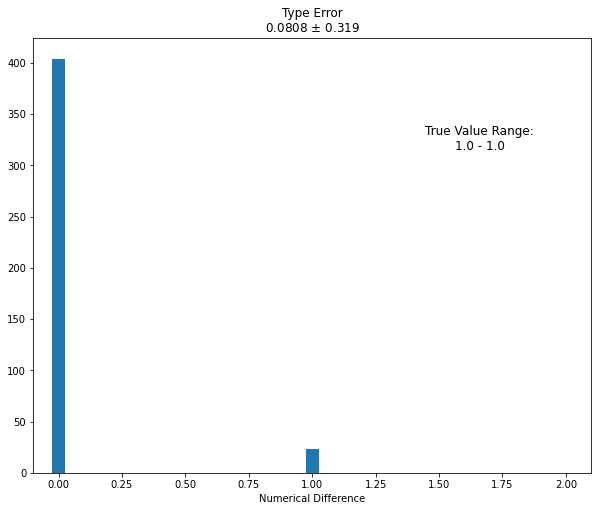

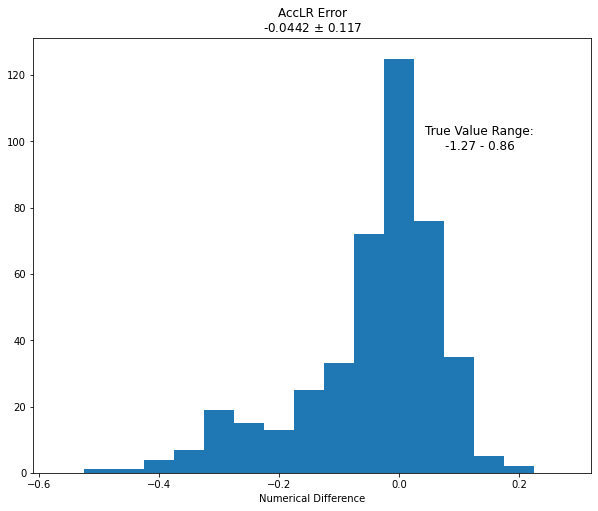

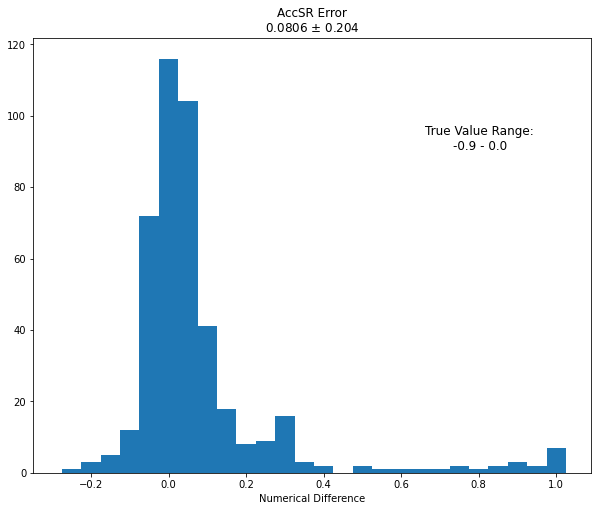

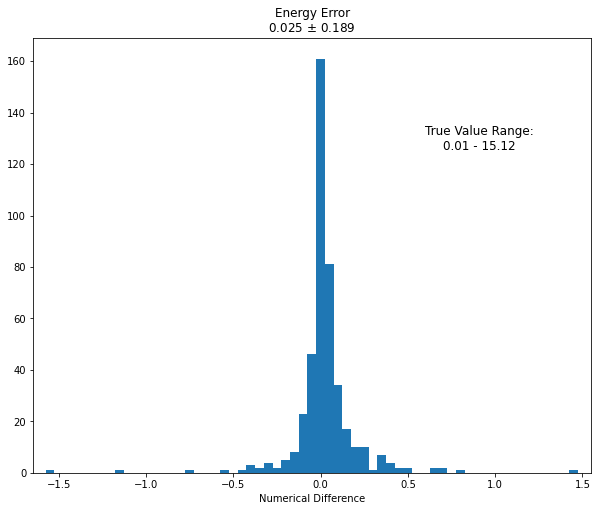

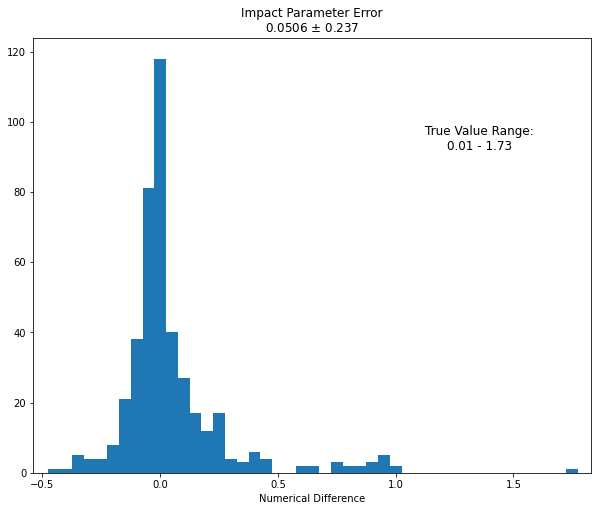

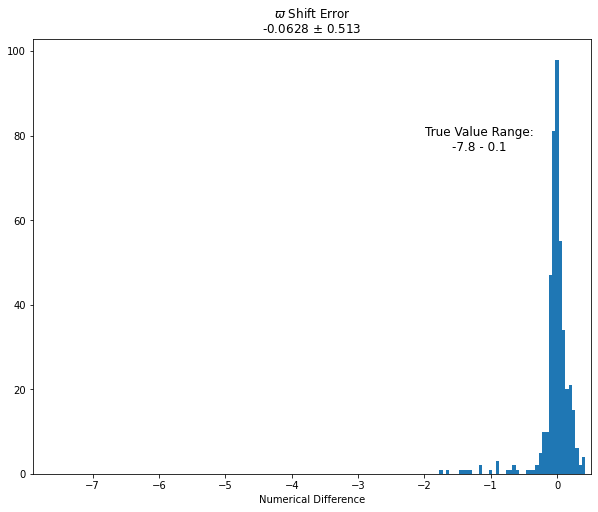

In [159]:
diffs = np.zeros((len(HNRs), 6))
for i in range(len(HNRs)):
    diffs[i] = (HNRs[i,4:] -  collcoll(*HNRs[i, :4]))
bins = np.arange(-2.025, 2.025, .05)
# plt.axvline(0, c='k', ls ='--')
labels = ["Type", "AccLR", "AccSR", "Energy", "Impact Parameter", "$\\varpi$ Shift"]
for i in range(6):
    plt.figure(figsize = (10, 8))
    plt.hist(diffs[:,i], bins)
    plt.xlabel('Numerical Difference')
    plt.title("{} Error\n{:.3} $\pm$ {:.3}".format(labels[i], np.mean(diffs[:,i]), np.std(diffs[:,i])))
    plt.xlim(min(diffs[:,i])-0.1, max(diffs[:,i])+0.1)
    plt.text(.8, .8, 'True Value Range:\n{} - {}'.format(min(HNRs[:, i+4]), max(HNRs[:, i+4])), ha='center', va='top', transform=plt.gca().transAxes, fontsize = 12)

In [139]:
HNRs[i,4:] -  collcoll(*HNRs[i, :4])

array([ 0.        ,  0.06277542, -0.06277542,  0.03061142, -0.01359265,
       -0.022842  ])

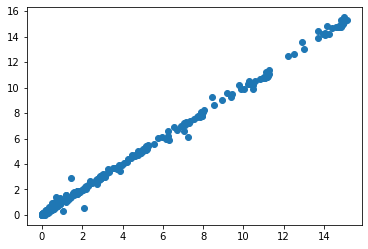

In [163]:
plt.scatter(HNRs[:, 7], diffs[:, 3] + HNRs[:, 7])